In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
from time import sleep
# from livelossplot import PlotLosses
import tensorflow as tf
import tensorflow.keras.initializers as initializers
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform
from scipy.special import softmax
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
from scipy.linalg import block_diag
sys.path.append('../models/')
sys.path.append('../')
from ratio_utils_highdim_exp_fam import *
tf.keras.backend.set_floatx('float32')
print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.15.0


-0.11452944806475547 0.11232284309318154


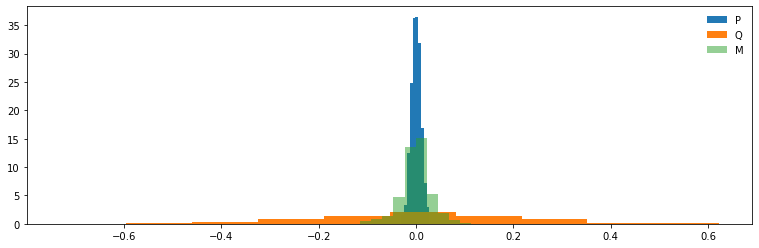

In [6]:
p_s = np.random.normal(0.,.01,1000)
q_s = np.random.normal(0,.2,1000)

# m_s = np.concatenate([np.random.normal(0.,.01,900),np.random.normal(0.,.1,100)],0)

alphas = np.random.uniform(-5.,5,size=1000)
m_s = [alpha*p for (alpha,p,q) in zip(alphas,p_s,q_s)]
# m_s = [np.sqrt(1-alpha**2)*p + (alpha)*q for (alpha,p,q) in zip(alphas,p_s,q_s)]
# m_s = np.sqrt(1-(.5)**2)*p_s + q_s*(.5)
fig, ax = plt.subplots(1, 1,figsize=(13,4))
ax.hist(p_s, density=True, histtype='stepfilled', alpha=0.99, label='P')
ax.hist(q_s, density=True, histtype='stepfilled', alpha=0.99, label='Q')
ax.hist(m_s, density=True, histtype='stepfilled', alpha=0.5, label='M')
ax.legend(loc='best', frameon=False)

print(min(m_s),max(m_s))

In [13]:
n_dims = 320
num_samples=100000
mi = 80
bs=1000
N=800
deep=False
reset(1)

def get_rho_from_mi(mi, n_dims):
    """Get correlation coefficient from true mutual information"""
    x = (4 * mi) / n_dims
    return (1 - np.exp(-x)) ** 0.5  # correlation coefficient
        
def get_data(mu_1=0.,mu_2=2.,mu_3=2.,scale_p=0.1,scale_q=0.1,scale_m=1.):
    
    p = tfd.MultivariateNormalFullCovariance(
        loc=mu_1,
        covariance_matrix=scale_p)
    
    q = tfd.MultivariateNormalDiag(
        loc=mu_2,
        scale_diag=scale_q)
      
    m = tfp.distributions.Mixture(
          cat=tfp.distributions.Categorical(probs=[.7,.3]),
          components=[
            p,
            q, 
        ])
    
#     m = tfp.distributions.MultivariateStudentTLinearOperator(
#     df=1.,
#     loc=mu_2,
#     scale=tf.linalg.LinearOperatorLowerTriangular(scale_m))
    
    p_samples_ = p.sample([num_samples]) 
    q_samples_ = q.sample([num_samples])
#     alpha = tf.expand_dims(tfd.Uniform (.6,1.).sample([num_samples]),1) #).15, 0.83 [0.01,0.33,0.5,.64,.99]
    alpha = tf.expand_dims(tf.reshape(tf.repeat([0.,0.25,0.5,.75,1.],num_samples//5),[num_samples]),1) #[0.05,0.25,0.6,.85,0.95] MI = 40
#     alpha = tf.expand_dims(tf.reshape(tf.repeat([0.,.125,.25,.375,.45,.55,.625,.75,.875,1.],num_samples//10),[num_samples]),1) MI = 120
#     alpha = 0.8
    m_samples_ = tf.sqrt(1-alpha**2)*p_samples_ + alpha*q_samples_ 
    m_samples_ = (1-alpha)*p_samples_ + alpha*q_samples_ 
    
#     m_samples_ = m.sample([num_samples])
    
    with tf.Session() as sess:
        p_,q_,m_ = sess.run([p_samples_, q_samples_, m_samples_],feed_dict={})
        sess.close() 
    
    return p, q, m, p_,q_,m_

# Define data param
rho = get_rho_from_mi(mi, n_dims)  # correlation coefficient
print(rho)
rhos = np.ones(n_dims // 2, dtype="float32") * rho

mu_1=-0.5+np.zeros((n_dims), dtype="float32")
mu_2=0.5+np.zeros((n_dims), dtype="float32")
mu_3=np.zeros((n_dims), dtype="float32")

scale_p = block_diag(*[[[1, rho], [rho, 1]] for _ in range(n_dims // 2)])
scale_p = np.float32(scale_p)
scale_q = np.ones(n_dims, dtype="float32")
scale_m = 1*np.eye(n_dims, dtype="float32")

# Generate dataset
p, q, m, p_list, q_list, m_list = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
_, _, _, p_list_test, _, m_list_test = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)

print(p_list.shape)

0.7950600976206501
(100000, 320)


[[-453.02087  -731.0723   -450.      ]
 [-432.47015  -627.5359   -450.      ]
 [ -40.945778 -316.8249   -450.      ]
 ...
 [ -40.945778 -316.8249   -450.      ]
 [-487.8194   -674.8052   -450.      ]
 [-447.01587  -605.70215  -450.      ]]
[[-684.1492  -585.6806  -588.17865]
 [-682.6917  -572.7612  -596.7259 ]
 [-655.2711  -580.45514 -615.3378 ]
 ...
 [-636.5603  -603.29694 -593.05664]
 [-691.30206 -558.61237 -580.5285 ]
 [-647.9652  -550.8047  -572.22864]]
[[-456.4293  -454.01584 -450.     ]
 [-468.43402 -465.1327  -450.     ]
 [-433.57382 -458.53116 -450.     ]
 ...
 [-453.3098  -508.6405  -450.     ]
 [-427.99054 -434.74274 -450.     ]
 [-435.1734  -606.253   -450.     ]]

5.51101e-19
0.0
0.0


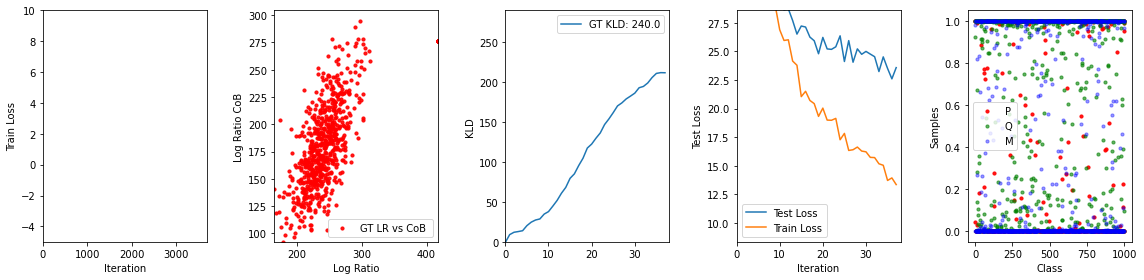

In [ ]:
p_samples = tf.placeholder(tf.float32, shape=[None,n_dims])
q_samples = tf.placeholder(tf.float32, shape=[None,n_dims])
m_samples = tf.placeholder(tf.float32, shape=[None,n_dims])

dloss = get_loss(p_samples, q_samples, m_samples, None, deep=deep)
optim = get_optim(dloss,lr=1e-3)#,lr=5e-3,b1=.99

log_ratio_p_q, _ = get_gt_ratio_kl(p,q,p_samples)
_, kl_from_pq = get_gt_ratio_kl(p,q,p_samples)
kl_from_cob = get_kl_from_cob(p_samples, q_samples)

log_ratio_p_m = get_logits(p_samples,deep=deep, training=False)
logit_q = get_logits(q_samples,deep=deep, training=False)
logit_m = get_logits(m_samples,deep=deep, training=False)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
[kl_gt] = sess.run([p.kl_divergence(q)],feed_dict={})

fig, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(1, 5,figsize=(16,4))

line, = ax1.plot([0,1],[0,1])
test_line, = ax4.plot([0,1],[0,1],label='Test Loss')
test_line1, = ax4.plot([0,1],[0,1],label='Train Loss')
kld_line, = ax3.plot([0],[0],label='GT KLD: '+str(kl_gt))
x, y = np.random.random((2, 500))
np.random.randint
scat = ax2.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')

scat_p = ax5.scatter(range(bs),np.random.randint(0,2,bs),label='P',alpha=0.9,s=10.,c='r')
scat_q = ax5.scatter(range(bs),np.random.randint(0,2,bs),label='Q',alpha=0.6,s=10.,c='g')
scat_m = ax5.scatter(range(bs),np.random.randint(0,2,bs),label='M',alpha=0.4,s=10.,c='b')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,N*(num_samples//bs)])
ax1.set_ylim([-5,10])

ax2.set_xlabel("Log Ratio")
ax2.set_ylabel("Log Ratio CoB")
ax2.legend(loc='best')

ax3.set_ylabel("KLD")
ax3.legend(loc='best')

ax4.set_xlabel("Iteration")
ax4.set_ylabel("Test Loss")
ax4.set_xlim([0,N//50])
ax4.set_ylim([-5,10])
ax4.legend(loc='best')

ax5.set_xlabel("Class")
ax5.set_ylabel("Samples")
ax5.legend(loc='best')


plt.tight_layout()
loss_store=[]
test_loss_store=[]
test_loss_store1=[]
kld_store=[]
pbar = range(0,N)
for j in pbar:
    for i in range(num_samples//bs):
        ps = p_list[np.random.choice(range(len(p_list)),bs)]
        qs = q_list[np.random.choice(range(len(q_list)),bs)]
        ms = m_list[np.random.choice(range(len(m_list)),bs)]
        feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
        
        l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
        loss_store.append(l)
        
        if i%100==0:
            line.set_data(range(len(loss_store)), loss_store)
            ax1.set_xlim( 0, len(loss_store) )
            
            ps = p_list_test[np.random.choice(range(len(p_list_test)),bs)]
            qs = q_list[np.random.choice(range(len(q_list)),bs)]
            ms = m_list_test[np.random.choice(range(len(m_list_test)),bs)]
            feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
            
            testl, lpq, lpqm, kl_cob, l_q, l_m = sess.run([dloss, log_ratio_p_q, log_ratio_p_m, kl_from_cob, logit_q, logit_m],feed_dict=feed_dict)
            kld_store.append(kl_cob)
            test_loss_store.append(testl)
            test_loss_store1.append(l)
#             cob = np.log([max(1e-10,n_[0]/n_[1]) for n_ in lpqm])
        
            cob=lpqm[:,0] - lpqm[:,1]
            scat.set_offsets(np.asarray([lpq,cob]).T)
            ax2.set_xlim( lpq.min(), lpq.max() )
#             ax2.set_ylim( lpq.min()-30, lpq.max()+10 )
            ax2.set_ylim( cob.min(), cob.max()+10 )

            kld_line.set_data(range(len(kld_store)),kld_store)
            ax3.set_xlim( 0, len(kld_store) )
            ax3.set_ylim( 0, kl_gt+50 )
#             ax3.set_ylim( 0, min(max(kld_store),500) )
            
            test_line1.set_data(range(len(test_loss_store1)), test_loss_store1)
            test_line.set_data(range(len(test_loss_store)), test_loss_store)
            ax4.set_xlim( 0, len(test_loss_store) )
            ax4.set_ylim([l.min()-5,testl.max()+5])
            
            
            
            scat_p.set_offsets(np.asarray([range(bs),softmax(lpqm,axis=1)[:,0]]).T)
            scat_q.set_offsets(np.asarray([range(bs),softmax(l_q, axis=1)[:,1]]).T)
            scat_m.set_offsets(np.asarray([range(bs),softmax(l_m, axis=1)[:,2]]).T)
            
             
            
            clear_output(wait=True)
            
            sp = (lpqm)
            sq = (l_q)
            sm = (l_m)
            print(sp)
            print(sq)
            print(sm)
            
            print(dloss.device)
            
            print(np.mean(np.exp(lpqm[:,0])))
            print(np.mean(np.exp(l_q[:,1])))
            print(np.mean(np.exp(l_m[:,2])))
            
#             if ( sp>0.99 and sq > 0.99 and sm>0.99 ):
#                 sys.exit(0)
                                                                                
            
            display(fig)
        


# sample_and_plot(sess, kld, kl_from_pq, kl_from_cob, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)



    

In [32]:
np.std(kld_store[-5:])

7.0587945

In [20]:
def kl(m1, s1, m2, s2):
    return np.log(s2)-np.log(s1)+(s1**2 + (m1-m2)**2)/(2*s2**2)-1/2

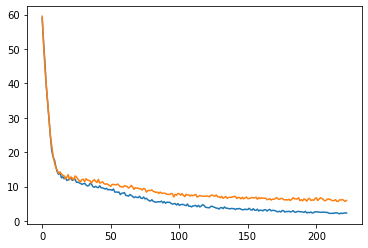

In [74]:
plt.plot(test_loss_store1[:])
plt.plot(test_loss_store[:])

In [119]:
(kld_store)

[1.6952966,
 1.7798133,
 6.550874,
 10.017588,
 12.17298,
 14.352085,
 16.17169,
 18.041306,
 17.702417,
 19.946114,
 20.63465,
 20.95625,
 20.54527,
 21.880987,
 24.040455,
 24.780142,
 24.890266,
 25.527515,
 26.07804,
 27.07059,
 26.679907,
 27.299023,
 26.557703,
 27.433714,
 28.051172,
 28.561237,
 28.262453,
 30.629555,
 29.070976,
 31.974966,
 29.31949,
 32.383125,
 31.212034,
 33.517124,
 33.771133,
 33.55163,
 33.708916,
 35.198025,
 34.98715,
 34.456306,
 36.69805,
 36.828804,
 36.502346,
 35.674973,
 35.432655,
 36.853493,
 39.247417,
 35.482506,
 42.147312,
 39.38999,
 37.164726,
 38.53191,
 41.551212,
 37.21286,
 39.971954,
 40.222137,
 44.02921,
 41.79677,
 38.419277,
 40.47752,
 46.408363,
 45.1106,
 45.12582,
 41.578804,
 46.832912,
 42.55866,
 45.49365,
 45.438564,
 45.075054,
 45.43744,
 48.52367,
 45.402897,
 44.995495,
 45.400127,
 44.754967,
 47.406265,
 45.208843,
 47.779858,
 44.411766,
 49.34396,
 inf,
 46.994503,
 45.40825,
 49.55635,
 48.201313,
 50.285374,
 4